In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, f1_score
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [2]:
train = pd.DataFrame(pd.read_csv('training_data.csv'))
test = pd.DataFrame(pd.read_csv('testing_data.csv'))

In [3]:
train.columns

Index(['id', 'campaign_id', 'coupon_id', 'customer_id', 'redemption_status',
       'date_diff', 'campaign_type_X', 'campaign_type_Y', 'type_Established',
       'type_Local', 'brand_small', 'brand_medium', 'brand_large',
       'cat_others', 'cat_pharmaceutical', 'cat_grocery', 'item_id',
       'quantity', 'selling_price', 'other_discount', 'coupon_discount',
       'dayofmonth', 'weekend', 'total_discount', 'cost_price',
       'percent_discount', 'coupon_disc_bin', 'marital_status', 'rented',
       'family_size', 'age', 'children_bin', 'lower', 'middle', 'upper',
       'childless', 'nuclear', 'extended'],
      dtype='object')

In [4]:
columns_drop = ['id','redemption_status']

X = train.drop(columns=columns_drop)
y = train['redemption_status']
Xtest = test.drop(columns=columns_drop)

In [5]:
X.shape, y.shape, Xtest.shape

((78369, 36), (78369,), (50226, 36))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
ns_probs = [0 for i in range(len(y_test))]

In [9]:
#clf = LogisticRegression(cv=5, random_state=0, max_iter=100)
clf = LogisticRegression(solver='newton-cg', class_weight='balanced')
clf.fit(X_train, y_train)

c:\users\hitman\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
clf.score(X_test, y_test)

0.8024901399737066

In [11]:
lr_probs = clf.predict_proba(X_test)

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.843


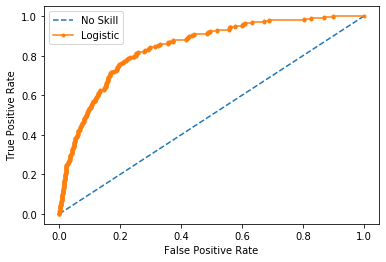

In [12]:
lr_prob = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_prob)

print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, ns_threshold = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, lr_threshold = roc_curve(y_test, lr_prob)

pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

pyplot.legend()
pyplot.show()

In [13]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8024901399737066

In [14]:
confusion_matrix(y_test, y_pred)

array([[20595,  5056],
       [   52,   159]], dtype=int64)

c:\users\hitman\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


No Skill: f1=0.000 auc=0.504
Logistic: f1=0.059 auc=0.048


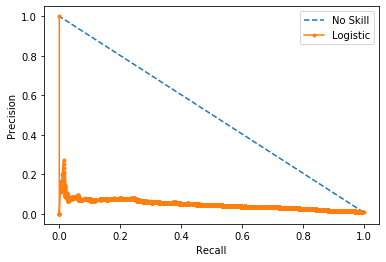

In [15]:
# Precision Recall curve
no_skill_probs = [0 for i in range(len(y_test))]
log_res_probs = clf.predict_proba(X_test)

log_res_prob = log_res_probs[:, 1]
y_pred = clf.predict(X_test)

ns_precision, ns_recall, no_skill_threshold = precision_recall_curve(y_test, no_skill_probs)
lr_precision, lr_recall, log_res_threshold = precision_recall_curve(y_test, log_res_prob)

ns_f1, ns_auc = f1_score(y_test, no_skill_probs), auc(ns_recall, ns_precision)
lr_f1, lr_auc = f1_score(y_test, y_pred), auc(lr_recall, lr_precision)

print('No Skill: f1=%.3f auc=%.3f' % (ns_f1, ns_auc))
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

pyplot.plot(ns_recall, ns_precision, linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

pyplot.legend()
pyplot.show()

In [39]:
# LGBM
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1500, reg_alpha=0.2,
                         colsample_bytree=0.5, bagging_fraction=1.0)
lgbm_clf.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test.values)],
            eval_metric='auc', early_stopping_rounds=100, verbose=200)

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.999484	training's binary_logloss: 0.0116857	valid_1's auc: 0.92827	valid_1's binary_logloss: 0.0347905
Early stopping, best iteration is:
[125]	training's auc: 0.997864	training's binary_logloss: 0.0160314	valid_1's auc: 0.929888	valid_1's binary_logloss: 0.0339216


LGBMClassifier(bagging_fraction=1.0, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=1500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.2, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [29]:
lgbm_p = lgbm_clf.predict_proba(X_test)[:,-1]
print(roc_auc_score(y_test, lgbm_p))

0.9298881763430045


In [30]:
lgbm_clf.feature_importances_

array([215, 647, 237, 146,  15,  20,  24,   7,  25,  20,   6,  10,  22,
        41, 243, 238, 212, 250, 348, 174,  19, 193, 193, 208,   1,  26,
        15,  87,  52,   6,   9,  19,   0,  10,   7,   5])

In [33]:
confusion_matrix(y_test, lgbm_p>0.5)

array([[25616,    35],
       [  198,    13]], dtype=int64)

In [37]:
sorted(zip(lgbm_clf.feature_importances_, X_train), reverse=True)

[(647, 'coupon_id'),
 (348, 'coupon_discount'),
 (250, 'other_discount'),
 (243, 'item_id'),
 (238, 'quantity'),
 (237, 'customer_id'),
 (215, 'campaign_id'),
 (212, 'selling_price'),
 (208, 'percent_discount'),
 (193, 'total_discount'),
 (193, 'cost_price'),
 (174, 'dayofmonth'),
 (146, 'date_diff'),
 (87, 'family_size'),
 (52, 'age'),
 (41, 'cat_grocery'),
 (26, 'marital_status'),
 (25, 'brand_small'),
 (24, 'type_Established'),
 (22, 'cat_pharmaceutical'),
 (20, 'campaign_type_Y'),
 (20, 'brand_medium'),
 (19, 'weekend'),
 (19, 'middle'),
 (15, 'rented'),
 (15, 'campaign_type_X'),
 (10, 'childless'),
 (10, 'cat_others'),
 (9, 'lower'),
 (7, 'type_Local'),
 (7, 'nuclear'),
 (6, 'children_bin'),
 (6, 'brand_large'),
 (5, 'extended'),
 (1, 'coupon_disc_bin'),
 (0, 'upper')]

In [80]:
err=[]
y_pred_tot=[]

feature_importance_df = pd.DataFrame()

from sklearn.model_selection import KFold,StratifiedKFold
fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1996)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m=LGBMClassifier(n_estimators=5000,random_state=1996,learning_rate=0.03,reg_alpha=0.2,colsample_bytree=0.5)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],eval_metric='auc', early_stopping_rounds=200,verbose=200)
    
    preds=m.predict_proba(X_test,num_iteration=m.best_iteration_)[:,-1]
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = X_train.columns
    fold_importance_df["importance"] = m.feature_importances_
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    
    print("err: ",roc_auc_score(y_test,preds))
    err.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(Xtest)[:,-1]
    i=i+1
    y_pred_tot.append(p)

Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.992077	training's binary_logloss: 0.0231331	valid_1's auc: 0.921468	valid_1's binary_logloss: 0.0367421
[400]	training's auc: 0.996933	training's binary_logloss: 0.017861	valid_1's auc: 0.923299	valid_1's binary_logloss: 0.0367658
Early stopping, best iteration is:
[232]	training's auc: 0.993225	training's binary_logloss: 0.0220692	valid_1's auc: 0.922404	valid_1's binary_logloss: 0.0365967
err:  0.9224035414593523
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.991022	training's binary_logloss: 0.0236229	valid_1's auc: 0.935998	valid_1's binary_logloss: 0.0352005
[400]	training's auc: 0.996644	training's binary_logloss: 0.0181918	valid_1's auc: 0.936899	valid_1's binary_logloss: 0.0347787
Early stopping, best iteration is:
[254]	training's auc: 0.993101	training's binary_logloss: 0.0219303	valid_1's auc: 0.937385	valid_1's binary_logloss: 0.0348434
err:  0.9373

In [81]:
np.mean(err,0)

0.9393044415469438

In [85]:
sub = pd.DataFrame()
sub['id'] = test['id']
sub['redemption_status']=np.mean(y_pred_tot,0)
sub.head()

,id,redemption_status
0,3,0.038404
1,4,0.002581
2,5,0.180510
3,8,0.000175
4,10,0.000291


In [86]:
sub.to_csv('lgbmsub.csv', index = False)

In [ ]:
# use class weights during training
# smote
# undersampling
# oversampling


In [ ]:
#submission = pd.DataFrame()
#submission['id'] = test['id']
#submission['redemption_status'] = y_pred
#submission.to_csv('RFRsub.csv', index = False)